In [1]:
import torch
import torch.nn as nn

from discriminator import *
from generator import *
from loss import *
from model import *

import matplotlib.pyplot as plt

[dataset/apple2orange/trainA]: 995 files discovered.
[dataset/apple2orange/trainB]: 1019 files discovered.


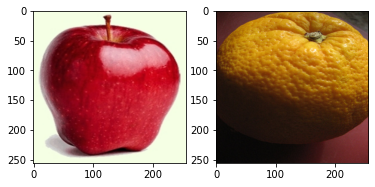

In [2]:
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

class CycleGANStandardDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.data = []
        
        # let the user overwrite the image preprocessing
        if not transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform
        
        for file in os.listdir(path):
            if os.path.isfile(os.path.join(path, file)):
                self.data.append(file)
        print('[%s]: %d files discovered.' % (path, len(self.data)))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data[idx]
        img = Image.open(os.path.join(self.path, img_name))
        
        img = self.transform(img)
        
        return img
    
path_a = 'dataset/apple2orange/trainA'
path_b = 'dataset/apple2orange/trainB'

dataA = CycleGANStandardDataset(path_a)
dataB = CycleGANStandardDataset(path_b)

plt.subplot(1, 2, 1)
plt.imshow(dataA.__getitem__(1).numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(dataB.__getitem__(1).numpy().transpose(1, 2, 0))

In [4]:
fixed_learning_rate_epoches = 100
linearly_decay_learning_learning_rate_epoches = 100
save_model_freq = 5
print_loss_freq = 10
batch_size = 1

dataloader = DataLoader(dataA, batch_size=batch_size, shuffle=True)
dataloaderB = DataLoader(dataB, batch_size=batch_size, shuffle=True)
model = CycleGAN()

total_iter_number = 0

for epoch in range(fixed_learning_rate_epoches+linearly_decay_learning_learning_rate_epoches):
    model.update_learning_rate()
    for i, data in enumerate(dataloader):  # inner loop within one epoch
        real_A = data
        real_B = next(iter(dataloaderB))        
        
        # forward (compute fake image and reconstruction images)
        fake_B, rec_A, fake_A, rec_B = model.forward(real_A, real_B)
        # G_A and G_B
        model.set_requires_grad([model.netD_A, model.netD_B], False)  # Ds require no gradients when optimizing Gs
        model.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        loss_G_list = model.backward_G(real_A, real_B, fake_A, fake_B, rec_A, rec_B)
        loss_G, loss_G_A, loss_G_B, loss_cycle_A, loss_cycle_B = loss_G_list
        model.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        model.set_requires_grad([model.netD_A, model.netD_B], True)
        model.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        loss_D_A = model.backward_D_A(real_A, fake_A)      # calculate gradients for D_A
        loss_D_B = model.backward_D_B(real_B, fake_B)      # calculate graidents for D_B
        model.optimizer_D.step()  # update D_A and D_B's weights   
        
        total_iter_number += 1        
        if total_iter_number % print_loss_freq == 0:
            print("[Epoch %d] Loss G: %f Loss_D: %f" % (epoch, loss_G, loss_D_A + loss_D_B))

[Epoch 0] Loss G: 24.019939 Loss_D: 1.552987


KeyboardInterrupt: 